# Data import section

In [1]:
import pandas as pd
import numpy as np
from google.colab import files

# Assuming the uploaded file is named 'DataSet-1.csv'
file_name = r'/content/drive/MyDrive/Colab Notebooks/DataSet-1.csv'

# Load your data
# Assuming Data is a DataFrame
# Read the CSV file, skipping the second row with units
Data = pd.read_csv(file_name, delimiter=',', decimal=',', quotechar='"', skiprows=[1])

# Reorder the columns
ordered_columns = ['Force', 'Time', 'Depth', 'S^2/P', 'Hardness', 'Modulus', 'XPosition', 'YPosition']
Data = Data[ordered_columns]
Data = Data.astype('float64')

# Clean NaN and data errors
threshold_value = 5000  # Define your threshold value on hardness

# Identify rows where Hardness values are NaN or greater than threshold_value
rows_to_remove = Data['Hardness'].isna() | (Data['Hardness'] > threshold_value)

# Remove these rows from the DataFrame
Data = Data[~rows_to_remove]

# Make Coordinates Relative to Smallest X and Smallest Y
minX = Data['XPosition'].min()
minY = Data['YPosition'].min()

# Temp variable for data operations
ZeroedData = Data.copy()

# Subtract the minimum X and Y values from all data points
ZeroedData['XPosition'] = Data['XPosition'] - minX
ZeroedData['YPosition'] = Data['YPosition'] - minY
ZeroedData['YPosition'] = Data['YPosition'].max() - Data['YPosition']
ZeroedData['XPosition'] = Data['XPosition'].max() - Data['XPosition']

# Remove outlayers section

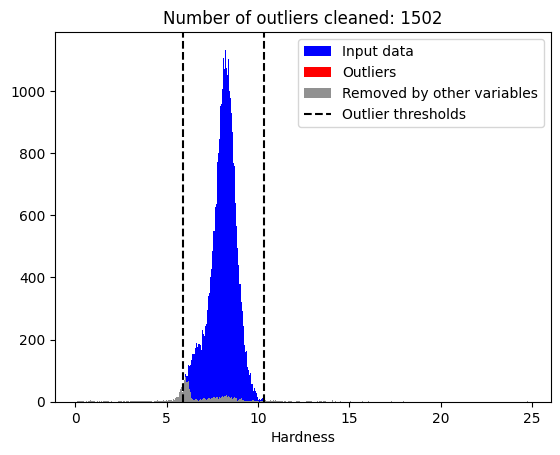

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming ZeroedData is already defined
# Remove outliers based on interquartile range (IQR)
treshold = 2
Q1 = ZeroedData[['Force', 'Time', 'Depth', 'S^2/P', 'Hardness', 'Modulus']].quantile(0.25)
Q3 = ZeroedData[['Force', 'Time', 'Depth', 'S^2/P', 'Hardness', 'Modulus']].quantile(0.75)
IQR = Q3 - Q1

thresholdLow = Q1 - treshold * IQR
thresholdHigh = Q3 + treshold * IQR

outliers = ((ZeroedData[['Force', 'Time', 'Depth', 'S^2/P', 'Hardness', 'Modulus']] < thresholdLow) |
            (ZeroedData[['Force', 'Time', 'Depth', 'S^2/P', 'Hardness', 'Modulus']] > thresholdHigh)).any(axis=1)

filteredData = ZeroedData[~outliers]
outliersForPlot = ZeroedData[outliers]

# Display results
plt.figure()
bin_edges = np.histogram_bin_edges(ZeroedData['Hardness'], bins='auto')
bin_edges = np.unique(np.concatenate((bin_edges, [thresholdLow['Hardness'], thresholdHigh['Hardness']])))
bin_edges = bin_edges[np.isfinite(bin_edges)]

# Plot input data
plt.hist(ZeroedData['Hardness'], bins=bin_edges, alpha=1, label='Input data', color='blue')

# Plot outliers
plt.hist(outliersForPlot['Hardness'], bins=bin_edges, alpha=1, label='Outliers', color='red')

# Plot data removed by other variables
mask = outliers & ~outliersForPlot['Hardness'].isna()
plt.hist(ZeroedData['Hardness'][mask], bins=bin_edges, alpha=1, label='Removed by other variables', color=[145/255, 145/255, 145/255])

# Plot outlier thresholds
plt.axvline(thresholdLow['Hardness'], color='black', linestyle='--', label='Outlier thresholds')
plt.axvline(thresholdHigh['Hardness'], color='black', linestyle='--')

plt.title(f"Number of outliers cleaned: {outliersForPlot.shape[0]}")
plt.legend()
plt.xlabel("Hardness")
plt.show()

# Data Statistics

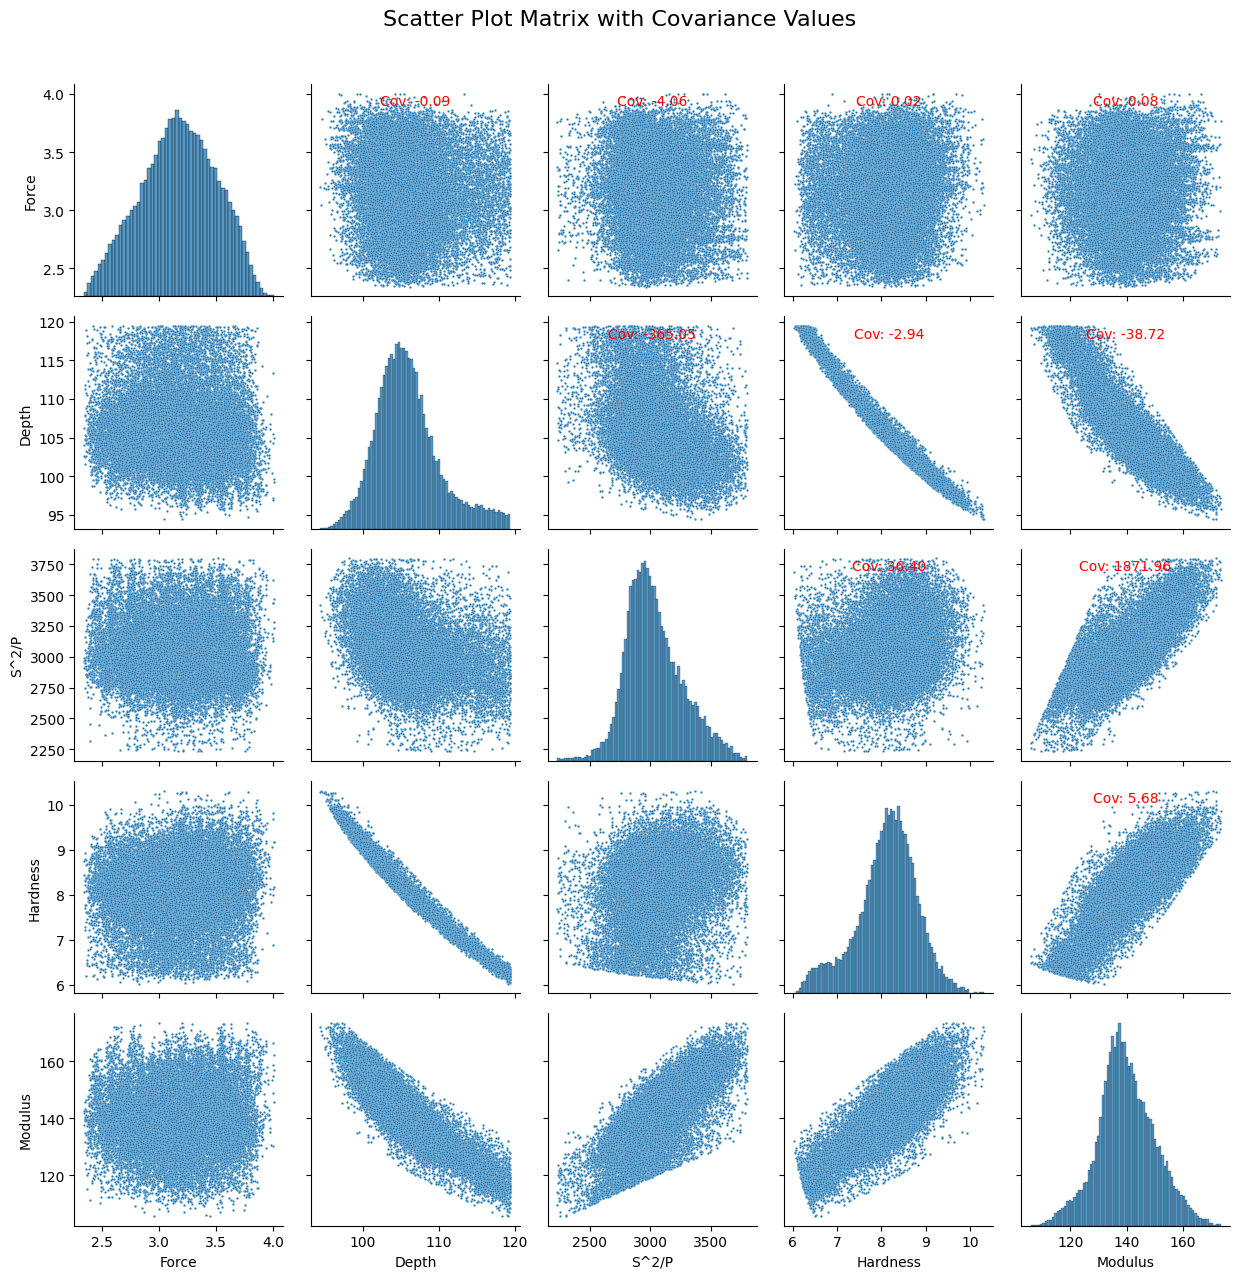

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming filteredData is a DataFrame with 'XPosition', 'YPosition', 'Modulus', and 'Hardness' columns

# Select the relevant columns
data = filteredData[['Force', 'Depth', 'S^2/P', 'Hardness', 'Modulus']]

# Compute the covariance matrix
cov_matrix = data.cov()

# Create a pairplot with scatter plots and histograms
pairplot = sns.pairplot(data, kind='scatter', diag_kind='hist', plot_kws={'s': 3})

# Add the covariance values to the plots
for i, j in zip(*np.triu_indices_from(cov_matrix, 1)):
    ax = pairplot.axes[i, j]
    ax.annotate(f'Cov: {cov_matrix.iloc[i, j]:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', ha='center', fontsize=10, color='red')

plt.suptitle('Scatter Plot Matrix with Covariance Values', y=1.02, fontsize=16)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


# High-speed maps plotting

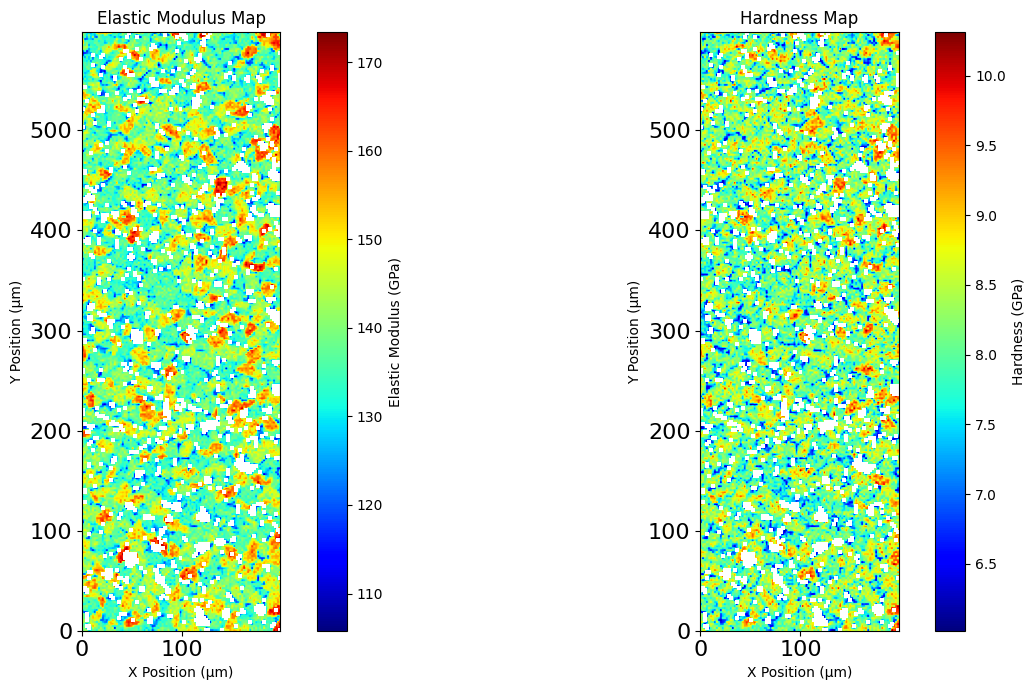

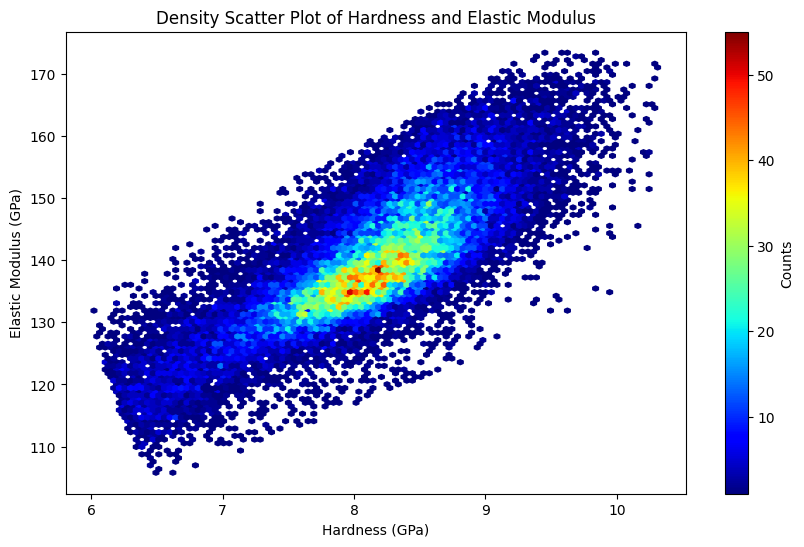

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming filteredData is a DataFrame

# Get the unique x and y positions
x_positions = np.unique(filteredData['XPosition'])
y_positions = np.unique(filteredData['YPosition'])

# Create grid to place the modulus and hardness values
modulus_grid = np.full((len(y_positions), len(x_positions)), np.nan)
hardness_grid = np.full((len(y_positions), len(x_positions)), np.nan)

# Fill the grids with modulus and hardness values
for i, x in enumerate(x_positions):
    for j, y in enumerate(y_positions):
        modulus_value = filteredData[(filteredData['XPosition'] == x) & (filteredData['YPosition'] == y)]['Modulus']
        hardness_value = filteredData[(filteredData['XPosition'] == x) & (filteredData['YPosition'] == y)]['Hardness']
        if not modulus_value.empty:
            modulus_grid[j, i] = modulus_value.values[0]
        if not hardness_value.empty:
            hardness_grid[j, i] = hardness_value.values[0]

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 7))  # Adjust the figsize as needed

# Plot Elastic Modulus Map
im1 = ax[0].imshow(modulus_grid, cmap='jet', origin='lower', extent=[x_positions.min(), x_positions.max(), y_positions.min(), y_positions.max()])
cb1 = plt.colorbar(im1, ax=ax[0])
cb1.set_label('Elastic Modulus (GPa)')
ax[0].set_xlabel('X Position (μm)')
ax[0].set_ylabel('Y Position (μm)')
ax[0].tick_params(labelsize=16)
ax[0].set_title('Elastic Modulus Map')

# Plot Hardness Map
im2 = ax[1].imshow(hardness_grid, cmap='jet', origin='lower', extent=[x_positions.min(), x_positions.max(), y_positions.min(), y_positions.max()])
cb2 = plt.colorbar(im2, ax=ax[1])
cb2.set_label('Hardness (GPa)')
ax[1].set_xlabel('X Position (μm)')
ax[1].set_ylabel('Y Position (μm)')
ax[1].tick_params(labelsize=16)
ax[1].set_title('Hardness Map')

# Adjust the aspect ratio to 1:1
for axis in ax:
    axis.set_aspect('equal')

# Tight layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

# Create the density scatter plot for Hardness and Modulus
plt.figure(figsize=(10, 6))

# Use hexbin to create a density plot
hb = plt.hexbin(filteredData['Hardness'], filteredData['Modulus'], gridsize=100, cmap='jet', mincnt=1)

# Add a colorbar
cb = plt.colorbar(hb)
cb.set_label('Counts')

# Set labels and title
plt.xlabel('Hardness (GPa)')
plt.ylabel('Elastic Modulus (GPa)')
plt.title('Density Scatter Plot of Hardness and Elastic Modulus')

# Show the plot
plt.show()

# Data normalization

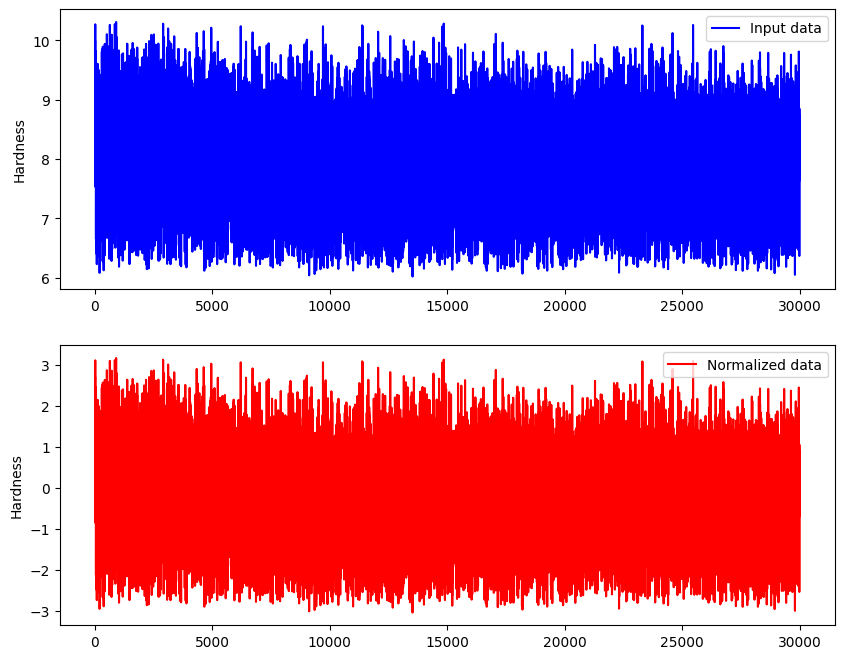

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Normalize Data
def normalize(data, columns):
    center_value = data[columns].mean()
    scale_value = data[columns].std()
    normalized_data = (data[columns] - center_value) / scale_value
    return normalized_data, center_value, scale_value

columns_to_normalize = ['Force', 'S^2/P', 'Hardness', 'Modulus']
nData, center_value, scale_value = normalize(filteredData, columns_to_normalize)

# Display results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot input data
ax1.plot(filteredData['Hardness'], label='Input data', color='blue')
ax1.legend()
ax1.set_ylabel('Hardness')

# Plot normalized data
ax2.plot(nData['Hardness'], label='Normalized data', color='red', linewidth=1.5)
ax2.legend()
ax2.set_ylabel('Hardness')

plt.show()


# PCA Analysis

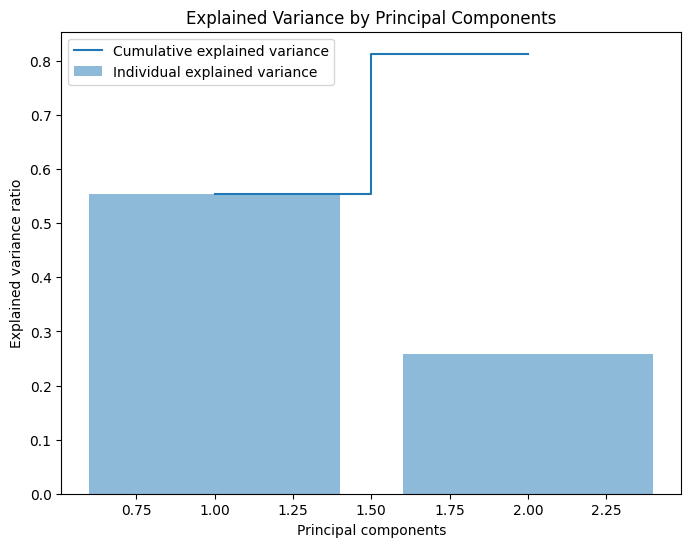

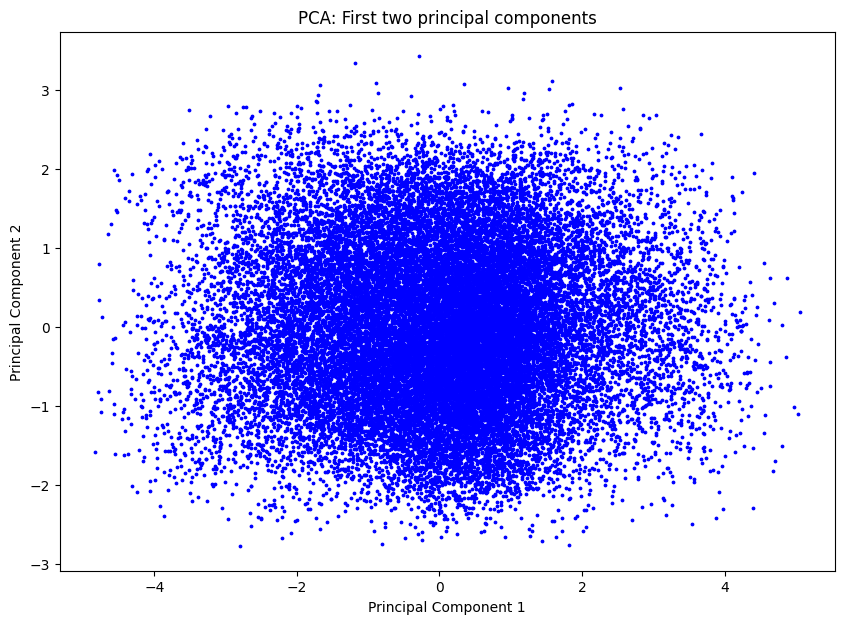

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Assuming filteredData is a DataFrame with 'XPosition', 'YPosition', 'Modulus', and 'Hardness' columns

# Select the relevant columns and standardize the data
features = ['Modulus', 'Hardness', 'Force', 'S^2/P']
x = nData.loc[:, features].values
x = StandardScaler().fit_transform(x)

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['Principal Component 1', 'Principal Component 2'])

# Plot the explained variance
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.title('Explained Variance by Principal Components')
plt.show()

# Plot the data in the space of the first two principal components
plt.figure(figsize=(10, 7))
plt.scatter(principalDf['Principal Component 1'], principalDf['Principal Component 2'], c='blue', s=3)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: First two principal components')
plt.show()

# DBSCAN clustering implementation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score

# Step 1: Prepare your data (assuming it's already normalized)
data = np.vstack((nData['Modulus'], nData['Hardness'])).T

# Step 2: Choose minpts
minpts = 10  # For 2D data, minpts is often set to 3

# Step 3: Compute the k-distance for each point
dist_matrix = pairwise_distances(data, metric='euclidean')
kD = np.sort(dist_matrix, axis=0)[minpts, :]
kDistance = np.sort(kD)

# Calculate the discrete derivative
kDistanceDerivative = np.diff(kDistance)

# Plot the original k-distance graph
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(kDistance)
plt.title('k-Distance Graph')
plt.xlabel('Points')
plt.ylabel('k-Distance')

# Plot the derivative of the k-distance graph
plt.subplot(2, 1, 2)
plt.plot(kDistanceDerivative)
plt.title('Derivative of k-Distance Graph')
plt.xlabel('Points')
plt.ylabel('Derivative of k-Distance')

# Identify the peak in the derivative plot (knee/elbow point)
kneeIndex = np.argmax(kDistanceDerivative)
print(f'Estimated epsilon value at index: {kneeIndex}')

# Step 5: Estimate epsilon from the k-distance graph
# You need to visually identify the knee/elbow point from the plot
# For example, if the knee is at index 100 in kDistance:
epsilon = kDistance[25940]

# Step 6: Run DBSCAN with the estimated epsilon and minpts
db = DBSCAN(eps=epsilon, min_samples=minpts).fit(data)
labels = db.labels_

# Count the number of clusters (excluding noise)
unique_labels = np.unique(labels)
num_clusters = len(unique_labels) - (1 if -1 in labels else 0)
cluster_sizes = np.array([np.sum(labels == x) for x in unique_labels])

# Plot the cluster sizes
plt.figure()
plt.bar(unique_labels[unique_labels != -1], cluster_sizes[unique_labels != -1])
plt.title('Cluster Sizes')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Points')

# Calculate silhouette values
s = silhouette_samples(data, labels, metric='euclidean')

# Calculate the average silhouette value
avg_silhouette = np.mean(s)

# Plot the silhouette values
plt.figure()
plt.bar(range(len(s)), s)
plt.title('Density-Based Silhouette Analysis')
plt.xlabel('Data Point Index')
plt.ylabel('Silhouette Value')

# Ask user for the threshold
threshold = 20

# Filter out clusters with fewer points than the threshold
valid_clusters = unique_labels[(cluster_sizes >= threshold) & (unique_labels != -1)]

# Visualize the filtered clusters
filtered_indices = np.isin(labels, valid_clusters)
plt.figure()
for cluster in valid_clusters:
    idx = labels == cluster
    plt.scatter(data[idx, 0], data[idx, 1], label=f'Cluster {cluster}', s=3)
plt.title('DBSCAN Clustering of Hardness and Modulus Data')
plt.xlabel('Normalized Modulus')
plt.ylabel('Normalized Hardness')
plt.legend(loc='best')
plt.show()

# Update the legend to reflect the number of clusters
cluster_legend = [f'Cluster {x}' for x in unique_labels if x != -1]
plt.legend(cluster_legend, loc='best')

# GMM Clustering

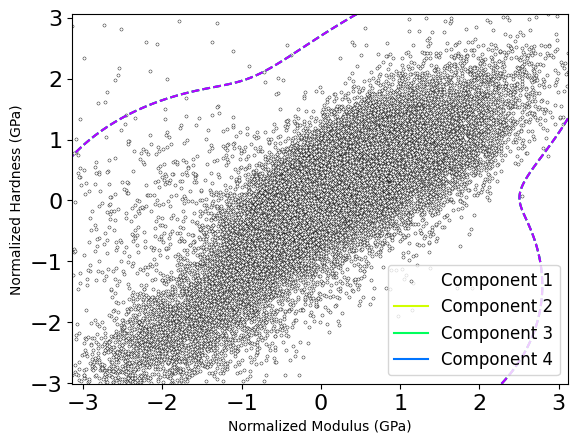

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import seaborn as sns

# Fit a Gaussian Mixture Model to Hardness and Modulus
numComponents = 4
data = np.column_stack((nData['Hardness'], nData['Modulus']))

gmm = GaussianMixture(n_components=numComponents, covariance_type='full', max_iter=10000, tol=1e-7, n_init=10, random_state=1)
gmm.fit(data)
clusterIndices = gmm.predict(data)

# Assuming 'XPosition' and 'YPosition' are available in 'filteredData'
# If not, adjust the code to use the appropriate DataFrame
data = np.column_stack((filteredData['XPosition'], filteredData['YPosition'], nData['Hardness'], nData['Modulus']))
clusterColors = sns.color_palette("hsv", numComponents)

plt.figure()
plt.scatter(data[:, 3], data[:, 2], s=5, edgecolor='k', facecolor='w', linewidth=0.3)

# Define limits for contour plot
xRange = np.linspace(data[:, 3].min(), data[:, 3].max(), 1000)
yRange = np.linspace(data[:, 2].min(), data[:, 2].max(), 1000)
XGrid, YGrid = np.meshgrid(xRange, yRange)

# Add contours for each Gaussian component with different colors
for i in range(numComponents):
    pdfValues = gmm.score_samples(np.column_stack((XGrid.ravel(), YGrid.ravel())))
    pdfValues = pdfValues.reshape(XGrid.shape)
    plt.contour(XGrid, YGrid, pdfValues, levels=1, linewidths=1.5, colors=[clusterColors[i]])

# Add invisible lines for legend
for i in range(numComponents):
    plt.plot([], [], linewidth=1.5, color=clusterColors[i])

# Create legend entries
legendEntries = [f'Component {x}' for x in range(1, numComponents+1)]
plt.legend(legendEntries, loc='best', fontsize=12)

plt.box(on=True)
plt.xlabel('Normalized Modulus (GPa)')
plt.ylabel('Normalized Hardness (GPa)')
plt.gca().tick_params(labelsize=16)
plt.show()

# K-means clustering




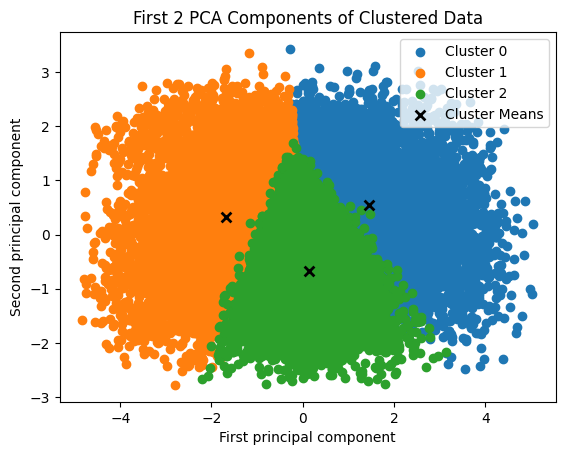

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# K-means clustering on Hardness and Modulus data
KData = np.column_stack((nData['Modulus'], nData['Hardness'], nData['Force'], nData['S^2/P']))


# Perform k-means clustering
K = 3
kmeans = KMeans(n_clusters=K, init='k-means++', n_init=10, random_state=1).fit(KData)
clusterIndices = kmeans.labels_

# PCA and plot
pca = PCA(n_components=2)
score = pca.fit_transform(KData)
clusterMeans = np.array([score[clusterIndices == i].mean(axis=0) for i in range(K)])

plt.figure()
for i in range(K):
    plt.scatter(score[clusterIndices == i, 0], score[clusterIndices == i, 1], label=f'Cluster {i}')
plt.scatter(clusterMeans[:, 0], clusterMeans[:, 1], c='k', s=50, marker='x', linewidths=2, label='Cluster Means')
plt.legend()
plt.title('First 2 PCA Components of Clustered Data')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.show()

# PDF deconvolution

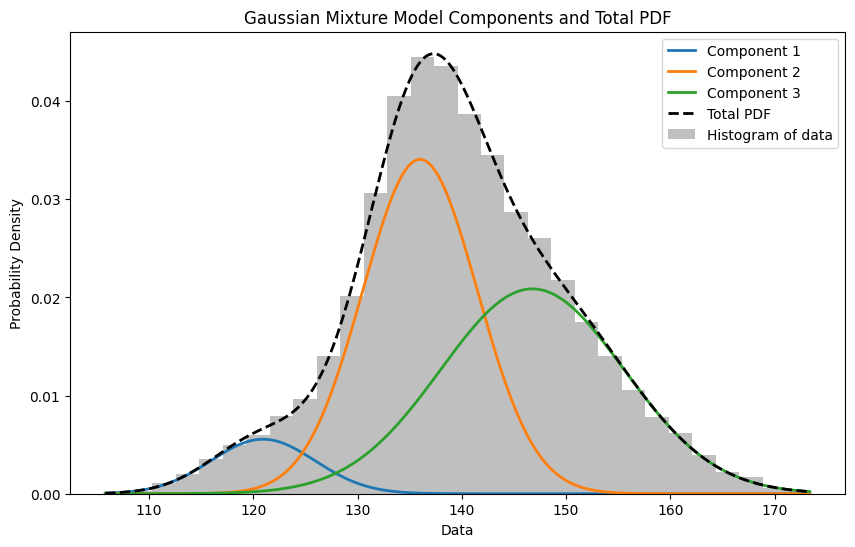

         Mean  StandardDeviation  Proportions
0  120.927413           4.987309      0.06942
1  135.997863           5.509129      0.47055
2  146.771985           8.790718      0.46003


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

def GMMdeconvo(data, numComponents):
    # Fit the GMM
    best_gmm = None
    best_bic = np.inf

    # Options equivalent to MATLAB's statset
    max_iter = 10000
    tol = 1e-7

    # Multiple random starts
    for _ in range(10):
        gmm = GaussianMixture(n_components=numComponents, max_iter=max_iter, tol=tol, n_init=10, random_state=1, reg_covar=0.001)
        gmm.fit(data.reshape(-1, 1))
        current_bic = gmm.bic(data.reshape(-1, 1))
        if current_bic < best_bic:
            best_bic = current_bic
            best_gmm = gmm

    # Assuming best_gmm is your fitted GMM model
    x_values = np.linspace(data.min(), data.max(), 1000)
    total_pdf = np.zeros_like(x_values)

    # Plot each Gaussian component
    plt.figure(figsize=(10, 6))
    for i in range(best_gmm.n_components):
        # For each component, calculate its PDF
        mean = best_gmm.means_[i][0]
        std = np.sqrt(best_gmm.covariances_[i][0][0])
        pdf_values = norm.pdf(x_values, mean, std)

        # Scale the PDF by the component's mixing proportion
        scaled_pdf = pdf_values * best_gmm.weights_[i]

        # Plot the component's PDF
        plt.plot(x_values, scaled_pdf, linewidth=2, label=f'Component {i+1}')

        # Add the scaled PDF to the total PDF
        total_pdf += scaled_pdf

    # Plot the total PDF
    plt.plot(x_values, total_pdf, 'k--', linewidth=2, label='Total PDF')

    # Plot the histogram of the data
    plt.hist(data, bins=30, density=True, alpha=0.5, color='gray', label='Histogram of data', edgecolor='none')

    plt.title('Gaussian Mixture Model Components and Total PDF')
    plt.xlabel('Data')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

    # Create the table with means, standard deviations, and proportions
    means = best_gmm.means_.flatten()
    std_devs = np.sqrt(best_gmm.covariances_.flatten())
    proportions = best_gmm.weights_

    GaussianComponents = pd.DataFrame({
        'Mean': means,
        'StandardDeviation': std_devs,
        'Proportions': proportions
    })

    return GaussianComponents

# Example usage
data = filteredData['Modulus'].values  # Replace 'Modulus' with the desired channel
numComponents = K  # Set the number of components
GaussianComponents = GMMdeconvo(data, numComponents)
print(GaussianComponents)

# Cluster Statistics

Cluster 1: Mean Modulus = 138.35, Std Modulus = 4.70, Mean Hardness = 8.27, Std Hardness = 0.41
Cluster 2: Mean Modulus = 153.78, Std Modulus = 5.62, Mean Hardness = 8.70, Std Hardness = 0.50
Cluster 3: Mean Modulus = 126.27, Std Modulus = 5.79, Mean Hardness = 7.10, Std Hardness = 0.46
Cluster 4: Mean Modulus = 140.05, Std Modulus = 5.03, Mean Hardness = 8.17, Std Hardness = 0.43


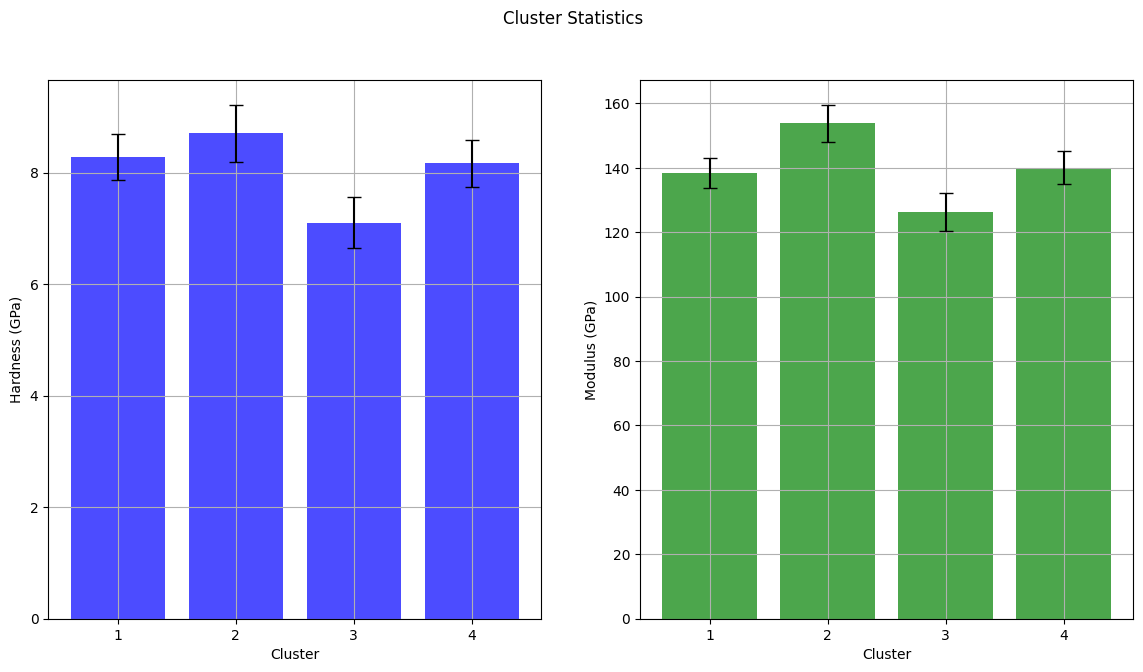

In [ ]:
# Calculate cluster statistics
meanModulusArray = np.zeros(K)
stdModulusArray = np.zeros(K)
meanHardnessArray = np.zeros(K)
stdHardnessArray = np.zeros(K)

for i in range(K):
    clusterData = filteredData[clusterIndices == i]
    meanModulusArray[i] = clusterData['Modulus'].mean()
    stdModulusArray[i] = clusterData['Modulus'].std()
    meanHardnessArray[i] = clusterData['Hardness'].mean()
    stdHardnessArray[i] = clusterData['Hardness'].std()
    print(f'Cluster {i+1}: Mean Modulus = {meanModulusArray[i]:.2f}, Std Modulus = {stdModulusArray[i]:.2f}, Mean Hardness = {meanHardnessArray[i]:.2f}, Std Hardness = {stdHardnessArray[i]:.2f}')

# Plot cluster statistics
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.bar(range(1, K+1), meanHardnessArray, yerr=stdHardnessArray, capsize=5, color='b', alpha=0.7)
plt.xlabel('Cluster')
plt.ylabel('Hardness (GPa)')
plt.xticks(range(1, K+1))
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar(range(1, K+1), meanModulusArray, yerr=stdModulusArray, capsize=5, color='g', alpha=0.7)
plt.xlabel('Cluster')
plt.ylabel('Modulus (GPa)')
plt.xticks(range(1, K+1))
plt.grid(True)

plt.suptitle('Cluster Statistics')
plt.show()

# Cluster plotting

IndexError: index 2 is out of bounds for axis 0 with size 2

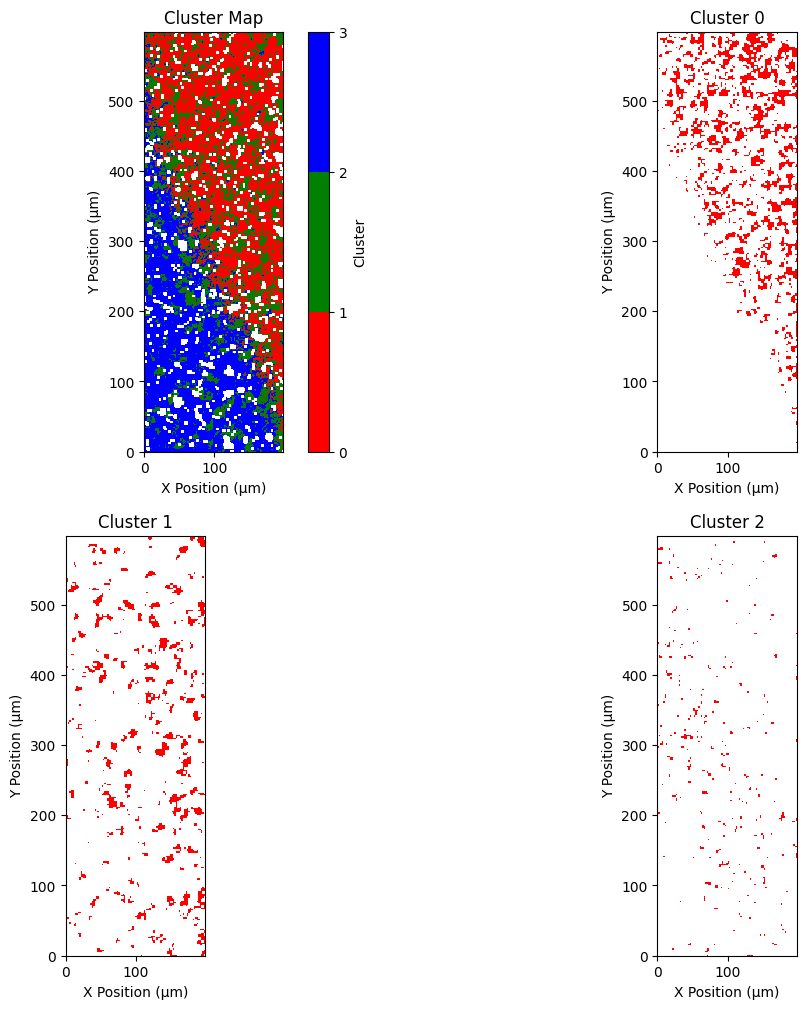

In [ ]:
from matplotlib.colors import ListedColormap

# Add clustering results to the filteredData using .loc to avoid the SettingWithCopyWarning
filteredData.loc[:, 'Cluster'] = clusterIndices

# Get the unique x and y positions
x_positions = np.unique(filteredData['XPosition'])
y_positions = np.unique(filteredData['YPosition'])

# Create a grid to place the cluster values
cluster_grid = np.full((len(y_positions), len(x_positions)), np.nan)

# Fill the grid with cluster values
for i, x in enumerate(x_positions):
    for j, y in enumerate(y_positions):
        cluster_value = filteredData[(filteredData['XPosition'] == x) & (filteredData['YPosition'] == y)]['Cluster']
        if not cluster_value.empty:
            cluster_grid[j, i] = cluster_value.values[0]

# Define a discrete colormap
cmap = ListedColormap(['red', 'green', 'blue'])

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot the main cluster map
im_main = axes[0, 0].imshow(cluster_grid, cmap=cmap, origin='lower', extent=[x_positions.min(), x_positions.max(), y_positions.min(), y_positions.max()])
cb_main = plt.colorbar(im_main, ax=axes[0, 0], ticks=np.arange(K))
cb_main.set_label('Cluster')
axes[0, 0].set_xlabel('X Position (μm)')
axes[0, 0].set_ylabel('Y Position (μm)')
axes[0, 0].set_title('Cluster Map')
axes[0, 0].set_aspect('equal', adjustable='box')

# Plot individual clusters
for cluster in range(K):
    cluster_data = filteredData[filteredData['Cluster'] == cluster]

    cluster_grid_individual = np.full((len(y_positions), len(x_positions)), np.nan)

    for i, x in enumerate(x_positions):
        for j, y in enumerate(y_positions):
            cluster_value = cluster_data[(cluster_data['XPosition'] == x) & (cluster_data['YPosition'] == y)]['Cluster']
            if not cluster_value.empty:
                cluster_grid_individual[j, i] = cluster_value.values[0]

    ax = axes[(cluster + 1) // 2, (cluster + 1) % 2]
    im = ax.imshow(cluster_grid_individual, cmap=cmap, origin='lower', extent=[x_positions.min(), x_positions.max(), y_positions.min(), y_positions.max()])
    ax.set_xlabel('X Position (μm)')
    ax.set_ylabel('Y Position (μm)')
    ax.set_title(f'Cluster {cluster}')
    ax.set_aspect('equal', adjustable='box')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()